In [1]:
#métricas y artefactos con MLflow
import pandas as pd
import numpy as np
#se puede acceder al archivo csv en el siguiente enlace: https://drive.google.com/drive/folders/155axDNF8oWJAo0rWz3ZzXWz34LD4XhrH?usp=sharing


In [2]:
# Instalar dependencias y configurar MLflow
!pip install mlflow pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62

In [3]:
# Importar librerías necesarias
# ---------------------------
import mlflow
import mlflow.sklearn
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pyngrok import ngrok
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt

In [4]:
# Configuración de MLflow y ngrok
mlflow.set_tracking_uri("databricks auth login")
mlflow.set_tracking_uri("file:/content/mlruns")
mlflow.set_experiment("modelo_msrp")
ngrok.set_auth_token("2wzPMwd9GV5Gmt8tAb8x3beLz2o_7Vr99HUFWwZjBJudxs13w")
mlflow_ui = ngrok.connect(5000)
get_ipython().system_raw("mlflow ui --port 5000 &")
print("MLflow UI disponible en:", mlflow_ui)

# Cargar dataset

df = pd.read_csv("/content/msrp_new.csv")


2025/05/16 20:59:58 INFO mlflow.tracking.fluent: Experiment with name 'modelo_msrp' does not exist. Creating a new experiment.


MLflow UI disponible en: NgrokTunnel: "https://6161-104-155-220-0.ngrok-free.app" -> "http://localhost:5000"


/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


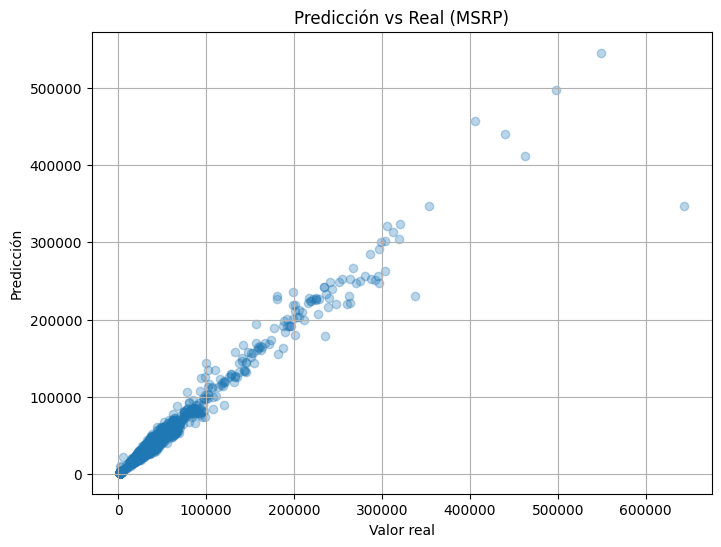

In [5]:
features = ['Make', 'Year', 'Engine Fuel Type', 'Engine HP', 'Engine Cylinders',
            'Vehicle Style', 'highway MPG', 'city mpg', 'Popularity']
target = 'MSRP'

X = df[features].copy()
y = df[target]

# Codificar variables categóricas
X = pd.get_dummies(X, drop_first=True)

# División del dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Entrenamiento y tracking con MLflow

with mlflow.start_run():
    model = ExtraTreesRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas de regresión
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2_score", r2)
    mlflow.log_param("random_state", 42)

    # Guardar el modelo
    model_path = "modelo_extra_trees.pkl"
    joblib.dump(model, model_path)
    mlflow.log_artifact(model_path)

    # Guardar dataset usado
    df.to_csv("msrp_logged.csv", index=False)
    mlflow.log_artifact("msrp_logged.csv")

    # Graficar pred vs real
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title("Predicción vs Real (MSRP)")
    plt.grid(True)
    plt.savefig("pred_vs_real.png")
    mlflow.log_artifact("pred_vs_real.png")

    # Guardar predicciones
    pred_df = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})
    pred_df.to_csv("predicciones_msrp.csv", index=False)
    mlflow.log_artifact("predicciones_msrp.csv")

    # Registrar el modelo con ejemplo
    mlflow.sklearn.log_model(model, "modelo_extra_trees", input_example=X.iloc[:2])


In [6]:
# Autenticarse con ngrok
ngrok.set_auth_token("2wzPMwd9GV5Gmt8tAb8x3beLz2o_7Vr99HUFWwZjBJudxs13w")

# Crear túnel al puerto 5000 donde corre MLflow
public_url = ngrok.connect(5000)
print(f"MLflow UI disponible en: {public_url}")

# 7. Lanzar la interfaz web de MLflow en segundo plano
os.system("mlflow ui --port 5000 &")


MLflow UI disponible en: NgrokTunnel: "https://3748-104-155-220-0.ngrok-free.app" -> "http://localhost:5000"


0